In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [253]:
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

def kalman_filt(z, X0, P0, F, Q, R, H):
    arr = np.zeros([200, 2])
    P = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    arr[0] = X0
    P[0] = P0
    for i in range(1, len(X)):
        arr[i] = np.dot(F, arr[i - 1].reshape(2, 1)).reshape(1, 2)
        P[i] = np.dot(np.dot(F, P[i - 1]), F.transpose()) + Q

        K[i] = (P[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(P[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)

        arr[i] = arr[i] + K[i] * (z[i] - np.dot(H, arr[i]))
        P[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(P[i])
        
    return arr, P, K, P[len(P) - 1], K[len(K) - 1]
        
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr

def backward_smooth(x, F, P):
    arr = np.array(x)
    Pn = np.array(P)
#     Pn[len(Pn) - 1] = np.array([[100, 0], [0, 100]])
    A = np.zeros([200, 2, 2])
#     A[len(A) - 1] = K_opt
    for i in range(len(arr) - 2, -1, -1):
        A[i] = (P[i].dot(F.transpose())).dot(np.linalg.inv(P[i+1]))
        arr[i] = x[i] + A[i].dot((x[i + 1] - F.dot(x[i])))
        Pn[i] = P[i] + (A[i].dot(Pn[i + 1] - P[i + 1])).dot(A[i].transpose())
    plt.plot(A[:,1,1])
    return arr, Pn, Pn[len(Pn) - 1]

In [254]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])
z = np.zeros(200)
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
for i in range(len(x)):
    z[i] = np.dot(H, X[i]) + eta[i]
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
R = sigmaeta_2
X0 = np.array([2, 0])
P0 = np.array([[100, 0], [0, 100]])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_35235/3875923402.py:25: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (P[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(P[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


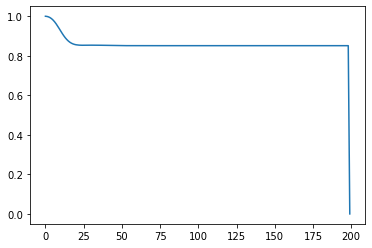

In [255]:
X_filt, P, K = kalman_filt(z, X0, P0, F, Q, R, H)[:3]
X_back, Pn = backward_smooth(X_filt, F, P)[:2]

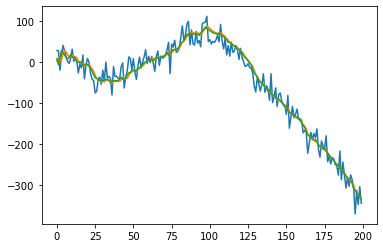

In [218]:
plt.plot(z)
plt.plot(X_filt[:, 0])
plt.plot(X_back[:, 0])
plt.show()

In [222]:
err = np.zeros([500, 197])
P_res = np.zeros([500, 2, 2])
smooth = backward_smooth(X_filt, F, P)
xf = smooth[0]
P_res[0] = smooth[2]
for i in range(1,500):
    smooth = backward_smooth(xf, F, P)
    xf = smooth[0]
    P_res[i] = smooth[2]
    err[i] = (X[3:, 0] - xf[3:, 0]) ** 2
final_err = np.zeros(500)
for i in range(500):
    final_err[i] = np.sqrt(np.mean(err[i]))

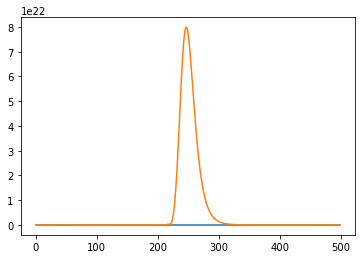

In [223]:
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(final_err)

In [230]:
print(final_err[0])
print(P_res[0, 0, 0] ** 0.5)

0.0
7.4552398724059765


In [213]:
print(final_err[499])
print(P_res[499, 0, 0] ** 0.5)

2665240946333.859
7.4552398724059765


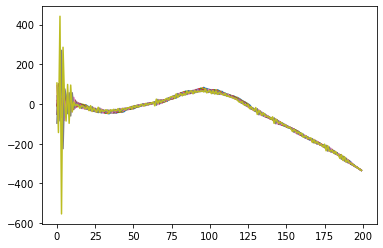

In [237]:
smooth = backward_smooth(X_filt, F, P)
xf = smooth[0]
P_res[0] = smooth[2]
for i in range(1, 10):
    smooth = backward_smooth(xf, F, P)
    xf = smooth[0]
    plt.plot(xf[:,0])